In [30]:
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#SK Learn
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

#Stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

from importlib import reload

#My imports
import wrangle as w
import env
import model as m

In [2]:
df = w.get_zillow_data()

In [3]:
df.head(2)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,transactiondate,parcelid
0,4.0,3.5,3100.0,6059.0,33634931.0,-117869207.0,4506.0,1998.0,1023282.0,2017-01-01,14297519
1,2.0,1.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,1967.0,464000.0,2017-01-01,17052889


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52442 non-null  float64
 1   bathroomcnt                   52442 non-null  float64
 2   calculatedfinishedsquarefeet  52360 non-null  float64
 3   fips                          52442 non-null  float64
 4   latitude                      52442 non-null  float64
 5   longitude                     52442 non-null  float64
 6   lotsizesquarefeet             52073 non-null  float64
 7   yearbuilt                     52326 non-null  float64
 8   taxvaluedollarcnt             52441 non-null  float64
 9   transactiondate               52442 non-null  object 
 10  parcelid                      52442 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 4.4+ MB


In [5]:
#Clean the data, removing nulls, duplicates, and outliers, recast certain feature types, returns df
df = w.clean_zillow(df)

In [6]:
df.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
0,4,3.5,3100.0,6059,33634931.0,-117869207.0,4506,1998,1023282,2017-01-01,14297519,Orange,19
1,2,1.0,1465.0,6111,34449266.0,-119281531.0,12647,1967,464000,2017-01-01,17052889,Ventura,50


In [7]:
#Splitting our data
train, validate, test = w.train_validate_test_split(df)

In [8]:
print(f' Train length is {len(train)} rows')
print(f' Validate length is {len(validate)} rows')
print(f' Test length is {len(test)} rows')

 Train length is 32903 rows
 Validate length is 7053 rows
 Test length is 7052 rows


# Exploration

In [11]:
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
51187,4,2.0,1607.0,6037,34117365.0,-117839192.0,7074,1958,137233,2017-09-12,13035327,Los Angeles,59
3300,3,2.5,2607.0,6111,34292708.0,-118681581.0,4195,2000,701000,2017-01-24,17240834,Ventura,17


In [12]:
#Breaking down continuous vs categorical variables
cat_vars = ['bedrooms', 'county']
cont_vars = ['bathrooms', 'square_feet', 'lot_size', 'tax_value', 'home_age']

In [13]:
def plot_categorical_and_continuous_vars(df, cat_vars, cont_vars):
    for col in cat_vars:
        for col2 in cont_vars:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))
            fig.suptitle(f'{col} vs. {col2}')
            sns.boxplot(data=df, x=col, y=col2, ax=ax1)
            sns.violinplot(data=df, x=col, y=col2, ax=ax2)
            sns.barplot(data=df, x=col, y=col2, ax=ax3)
            plt.show()

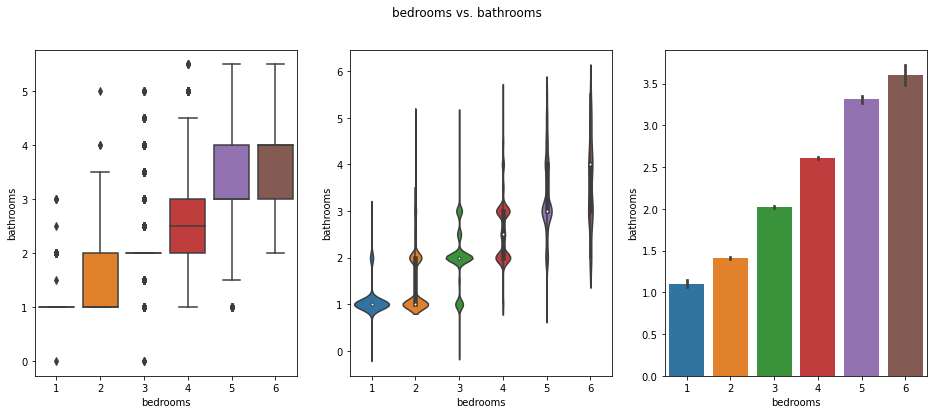

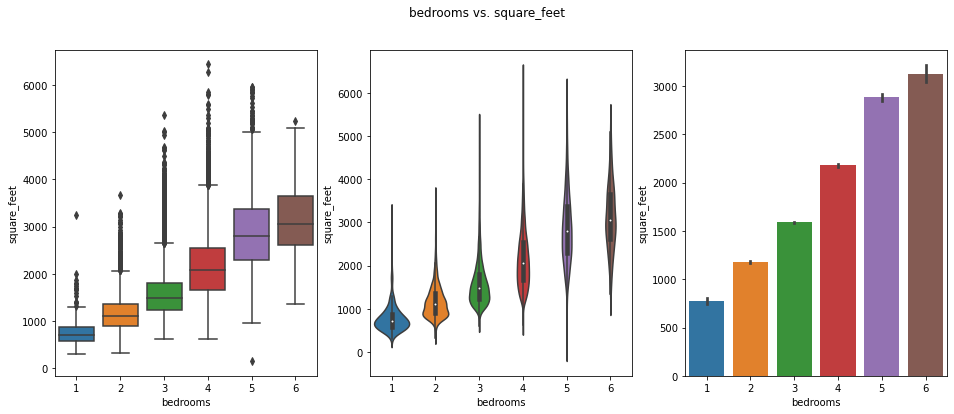

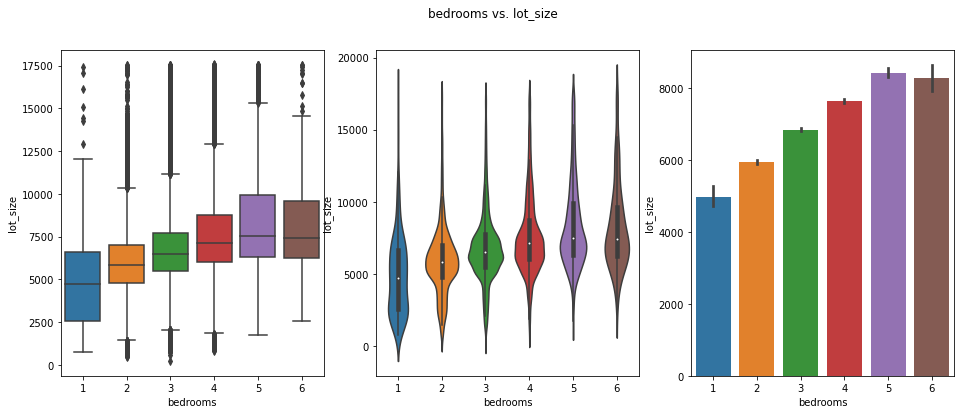

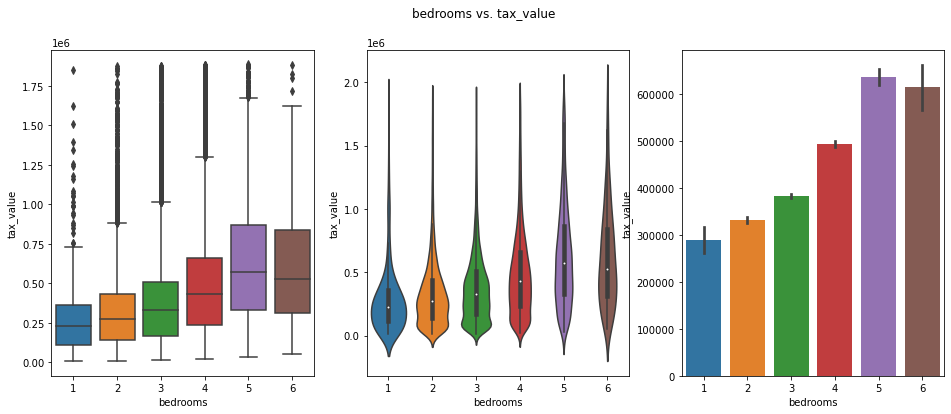

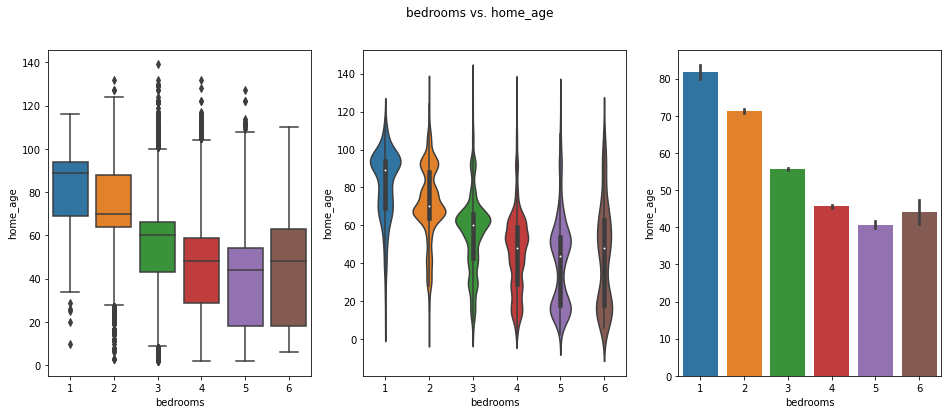

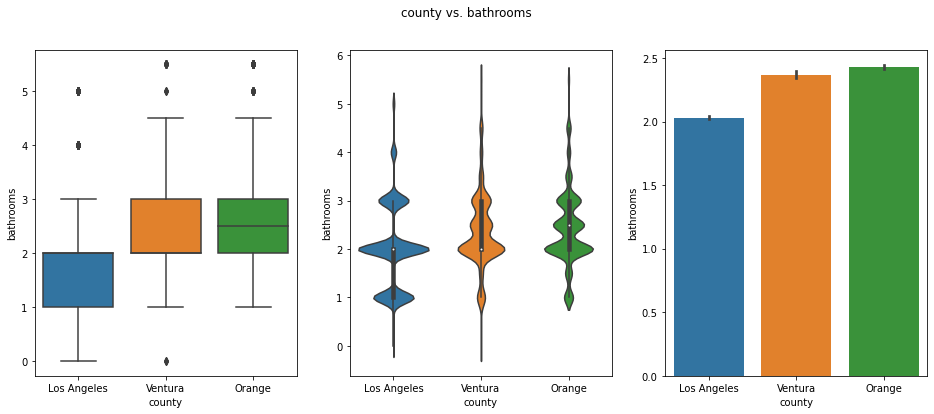

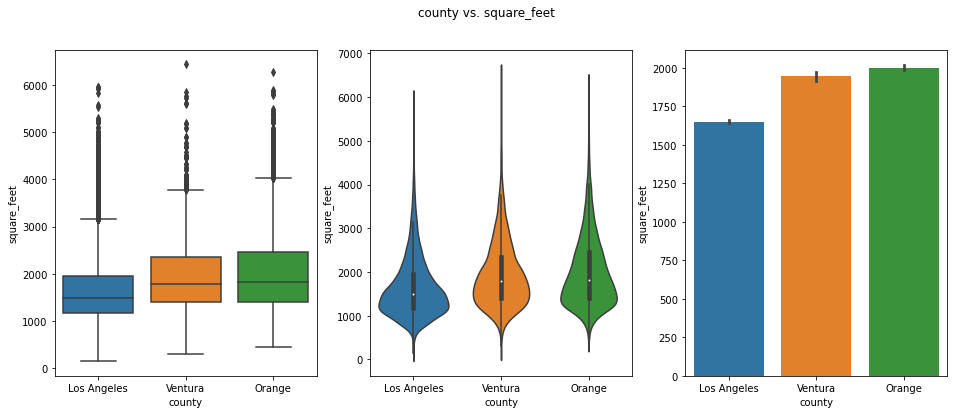

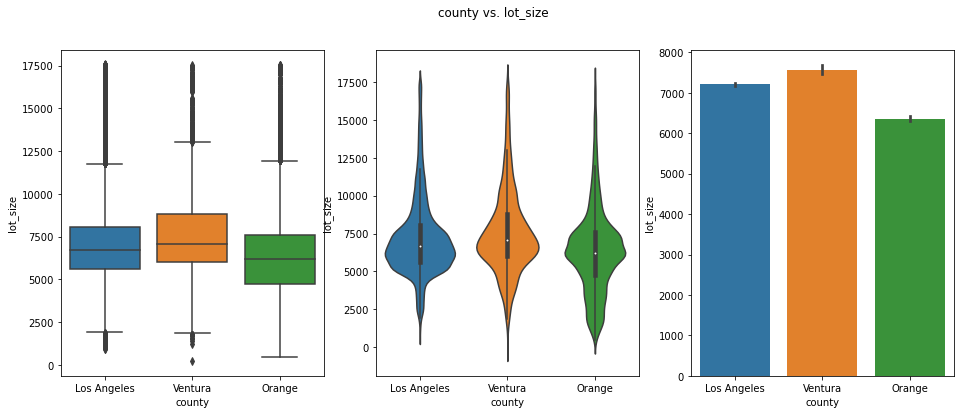

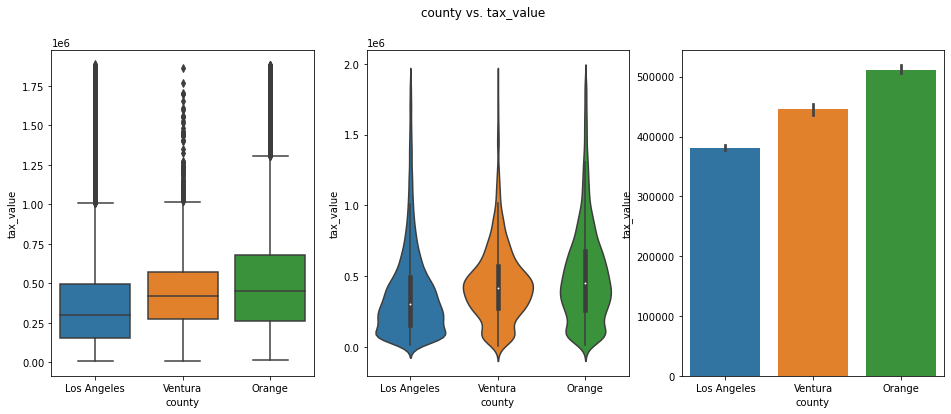

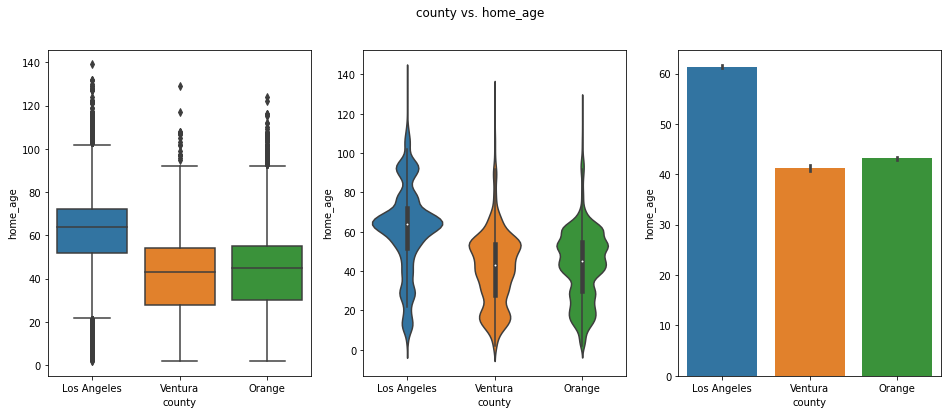

In [14]:
plot_categorical_and_continuous_vars(train, cat_vars, cont_vars)

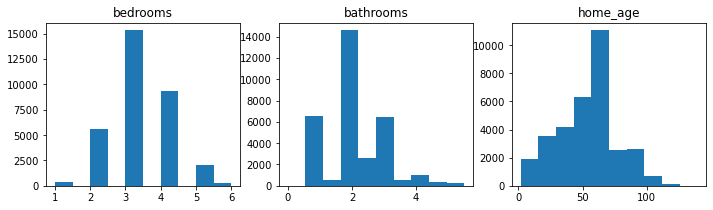

In [16]:
plt.figure(figsize=(16, 3))

# List of columns
cols = ['bedrooms', 'bathrooms', 'home_age', 'square_feet', '']
for i, col in enumerate(cols):
    # i starts at 0, but plot nos should start at 1
    subplot_num = i+1
    # Create subplot.
    plt.subplot(1,4,subplot_num)
    # Title with column name.
    plt.title(col)
    # Display histogram for column.
    train[col].hist(bins=10)
    # Hide gridlines.
    plt.grid(False)

bedrooms
3    15304
4     9359
2     5555
5     2065
1      357
6      263
Name: bedrooms, dtype: int64
3    46.512476
4    28.444215
2    16.882959
5     6.276023
1     1.085007
6     0.799319
Name: bedrooms, dtype: float64


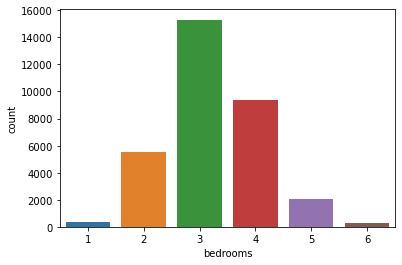

county
Los Angeles    21057
Orange          9155
Ventura         2691
Name: county, dtype: int64
Los Angeles    63.997204
Orange         27.824211
Ventura         8.178586
Name: county, dtype: float64


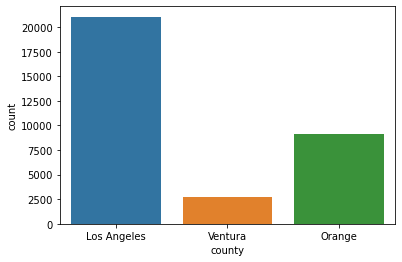

In [17]:
for col in cat_vars:
    print(col)
    print(train[col].value_counts())
    print(train[col].value_counts(normalize=True)*100)
    sns.countplot(x=col, data=train)
    plt.show()

### Bedrooms

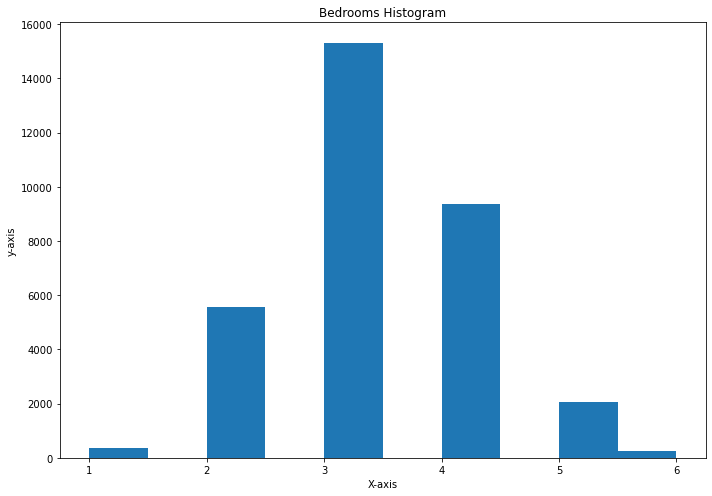

In [18]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7), tight_layout = True)
ax.hist(train.bedrooms)
plt.xlabel("X-axis")
plt.ylabel("y-axis")
plt.title('Bedrooms Histogram')
 
# Show plot
plt.show()

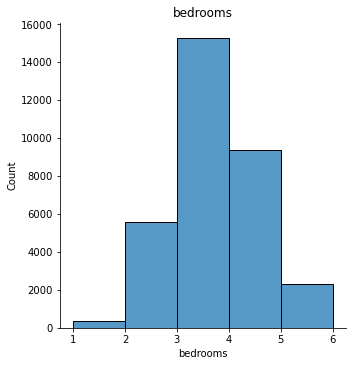

In [19]:
#Displot
sns.displot(x='bedrooms', data=train, bins=5)
plt.title('bedrooms')
plt.show()

### Continuous Variable Exploration

Mean bathrooms is: 2.168708020545239


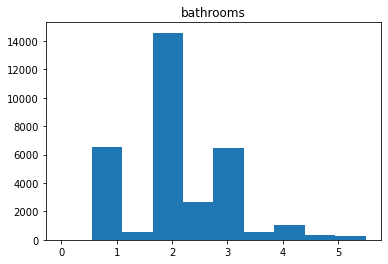

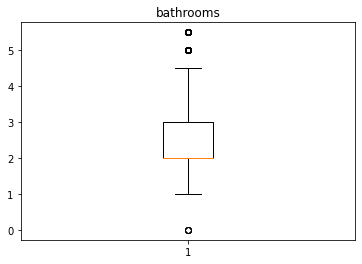

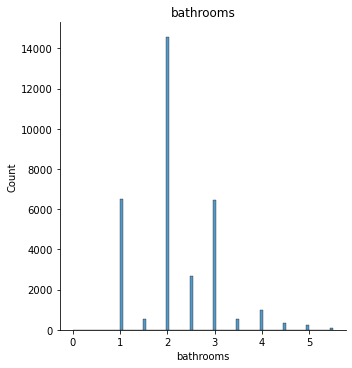

Mean square_feet is: 1771.0158040300278


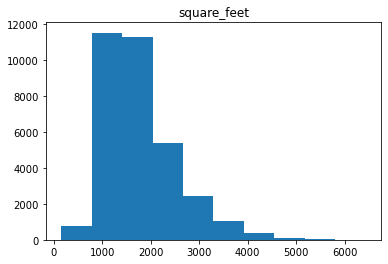

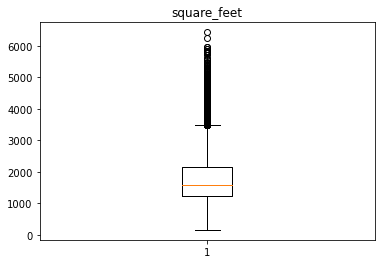

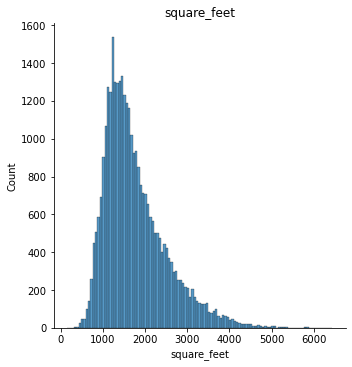

Mean lot_size is: 7001.801993739173


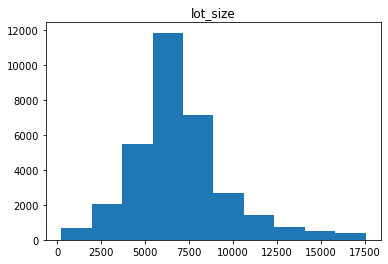

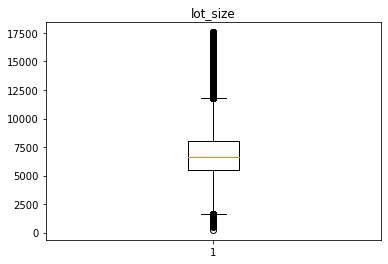

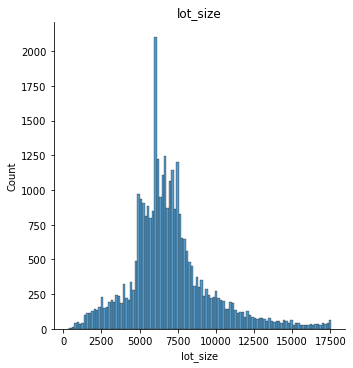

Mean tax_value is: 422949.6729173632


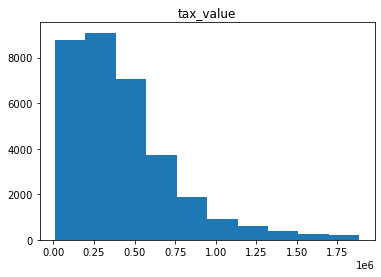

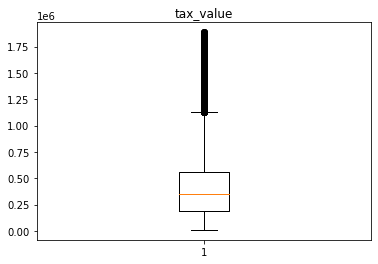

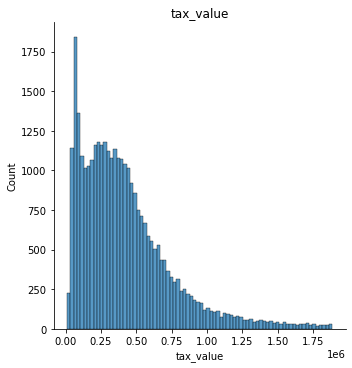

Mean home_age is: 54.67817524237911


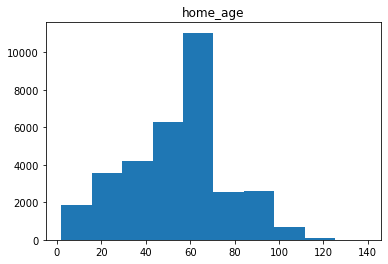

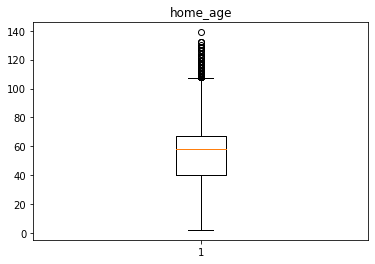

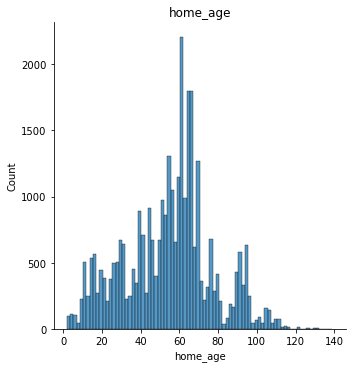

In [20]:
#Visualize other numeric data
# Plot numeric columns
for col in cont_vars:
    print(f'Mean {col} is: {train[col].mean()}')
    plt.hist(train[col])
    plt.title(col)
    plt.show()
    plt.boxplot(train[col])
    plt.title(col)
    plt.show()
    sns.displot(train[col])
    plt.title(col)
    plt.show()

In [21]:
#Descriptive statistics
print(f'Mean bedrooms = {train.bedrooms.mean()}')
print(f'Median Bedrooms = {train.bedrooms.median()}')
print(f'Mode Bedrooms = {train.bedrooms.mode()}')
print(f'Max Bedrooms = {train.bedrooms.max()}')
print(f'Min Bedrooms = {train.bedrooms.min()}')

Mean bedrooms = 3.2434124547913563
Median Bedrooms = 3.0
Mode Bedrooms = 0    3
Name: bedrooms, dtype: int64
Max Bedrooms = 6
Min Bedrooms = 1


In [22]:
#Bathrooms in train data set
train.bathrooms.value_counts()

2.0    14570
1.0     6527
3.0     6437
2.5     2653
4.0     1008
1.5      542
3.5      515
4.5      345
5.0      229
5.5       73
0.0        4
Name: bathrooms, dtype: int64

In [23]:
#Descriptive statistics of bathrooms
print(f'Mean Bathrooms = {train.bathrooms.mean()}')
print(f'Median Bathrooms = {train.bathrooms.median()}')
print(f'Mode Bathrooms = {train.bathrooms.mode()}')
print(f'Max Bathrooms = {train.bathrooms.max()}')
print(f'Min Bathrooms = {train.bathrooms.min()}')

Mean Bathrooms = 2.168708020545239
Median Bathrooms = 2.0
Mode Bathrooms = 0    2.0
Name: bathrooms, dtype: float64
Max Bathrooms = 5.5
Min Bathrooms = 0.0


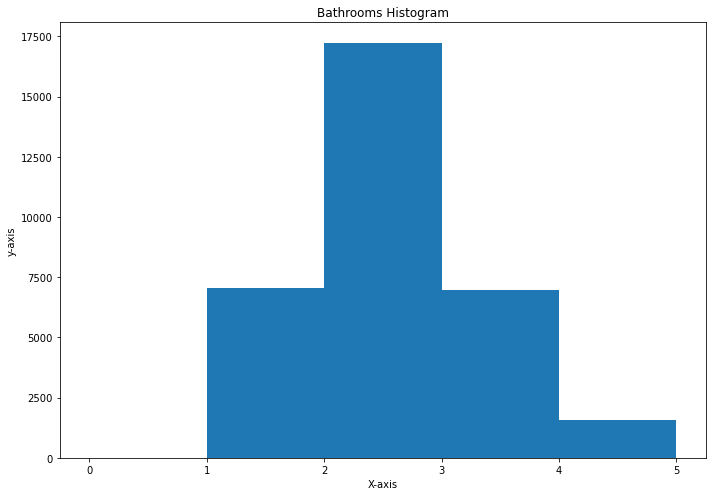

In [24]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7), tight_layout = True)
ax.hist(train.bathrooms, bins = [0, 1,2,3,4,5])
plt.xlabel("X-axis")
plt.ylabel("y-axis")
plt.title('Bathrooms Histogram')
 
# Show plot
plt.show()

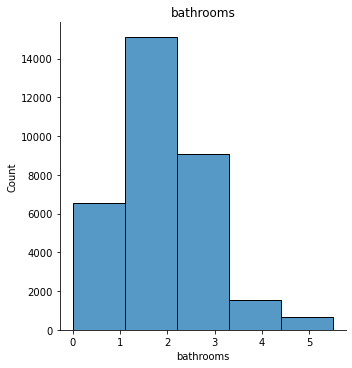

In [25]:
#Displot
sns.displot(x='bathrooms', data=train, bins=5)
plt.title('bathrooms')
plt.show()

In [ ]:
sns.pairplot(train)

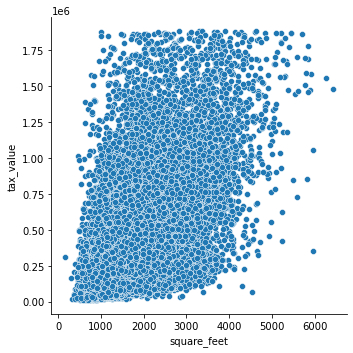

In [26]:
#Square Feet versus tax Value
sns.relplot(train['square_feet'], train['tax_value'], data=train)

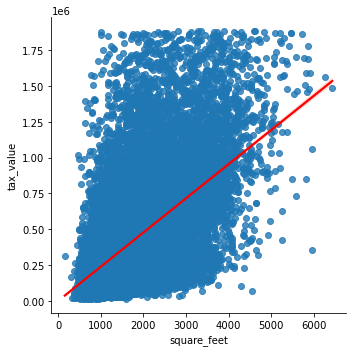

In [27]:
#Square Feet versus tax Value
sns.lmplot(x='square_feet', y='tax_value', data=train, scatter=True, line_kws={'color': 'red'})

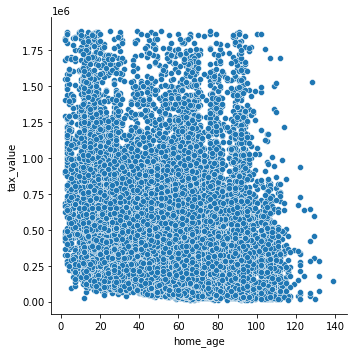

In [28]:
#bathrooms versus tax Value
sns.relplot(train['home_age'], train['tax_value'], data=train)

In [40]:
two_bedroom = train[train.bedrooms == 2]

In [41]:
one_bath = train[train.bathrooms == 1]

In [42]:
two_bedroom.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
25795,2,1.0,783.0,6037,34178740.0,-118511199.0,5608,1949,132983,2017-05-22,10850649,Los Angeles,68
45300,2,1.0,1364.0,6037,33781587.0,-118193383.0,4003,1910,158325,2017-08-16,12552916,Los Angeles,107


## County

In [10]:
LA = train[train.county == 'Los Angeles']
Orange = train[train.county == 'Orange']
Ventura = train[train.county == 'Ventura']

In [11]:
print(f'LA Mean Tax Value is: {round(LA.tax_value.mean())}')
print(f'Orange Mean Tax Value is: {round(Orange.tax_value.mean())}')
print(f'Ventura Mean Tax Value is: {round(Ventura.tax_value.mean())}')

LA Mean Tax Value is: 381318
Orange Mean Tax Value is: 511998
Ventura Mean Tax Value is: 445766


In [12]:
print(f'Count of properties in LA is: {len(LA.value_counts())}')
print(f'Count of properties in Orange is: {len(Orange.value_counts())}')
print(f'Count of properties in Ventura is: {len(Ventura.value_counts())}')

Count of properties in LA is: 21057
Count of properties in Orange is: 9155
Count of properties in Ventura is: 2691


#### The proportion of LA properties in train is 64 percent--while Ventura is only 8 percent. By including LA in the dataset, properties that are in LA county or not, this could be useful in predicting price. Properties outside of LA seem more valuable

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

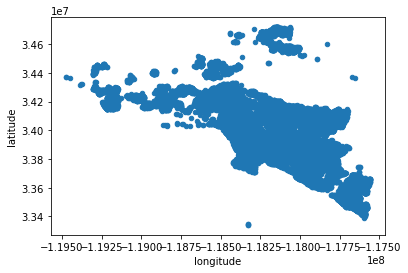

In [59]:
train.plot(x="longitude", y="latitude", kind="scatter", colormap="YlOrRd")

In [23]:
#Attempting to create a LA/Non-LA column
LA = train[train.county == 'Los Angeles']
not_LA = train[train.county != 'Los Angeles']

In [ ]:
df = df.groupby(
        np.where(df['Location'].isin(['E', 'F', 'G']), 'Other', df.Location)
    ).sum().reset_index().rename(columns={'index':'Location'})

# Modeling Iteration 1

### Scaling Data

In [9]:
#Scaling data for modeling
train, validate, test = m.scale_data(
    train, validate, test, columns_to_scale=[
        'bedrooms', 'bathrooms', 'square_feet','lot_size','home_age'],return_scaler=False)

In [10]:
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
51187,0.6,0.363636,0.231577,6037,34117365.0,-117839192.0,0.394667,1958,137233,2017-09-12,13035327,Los Angeles,0.416058
3300,0.4,0.454545,0.390737,6111,34292708.0,-118681581.0,0.228501,2000,701000,2017-01-24,17240834,Ventura,0.109489


### Creating dummy variables for county

In [11]:
train = pd.get_dummies(train, columns=['county'], drop_first=False)
validate = pd.get_dummies(validate, columns=['county'], drop_first=False)
test = pd.get_dummies(test, columns=['county'], drop_first=False)

--------------------------------

### Modeling Iteration 1

In [14]:
#Prep data for modeling iteration 1
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model1_prep(train, validate, test)

In [15]:
X_train.head(2)

,bedrooms,bathrooms,square_feet
0,0.6,0.363636,0.231577
1,0.4,0.454545,0.390737


### MVP Model Calculation Using OLS (Bedrooms, Bathrooms, Square Feet vs Tax Value)-Model 1

In [16]:
#Create Baseline using median
baseline = train.tax_value.mean()
baseline

422949.6729173632

In [17]:
y_train.head(2)

,tax_value
0,137233
1,701000


In [18]:
m1_eval = y_train.copy()
m1_eval = m1_eval.rename(columns={'tax_value': 'actual'})

In [21]:
m1_eval['baseline_yhat'] = m1_eval['actual'].mean()
m1_eval.head(2)

,actual,baseline_yhat
0,137233,422949.672917
1,701000,422949.672917


In [22]:
m1_eval['residuals'] = m1_eval.baseline_yhat - m1_eval.actual
m1_eval.head(2)

,actual,baseline_yhat,residuals
0,137233,422949.672917,285716.672917
1,701000,422949.672917,-278050.327083


In [23]:
#Initialize LR
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_value)

LinearRegression(normalize=True)

In [25]:
#Make Predictions
m1_eval['ols_yhat'] = lm.predict(X_train)
m1_eval.head()

,actual,baseline_yhat,residuals,ols_yhat
0,137233,422949.672917,285716.672917,322399.001913
1,701000,422949.672917,-278050.327083,660560.056612
2,182017,422949.672917,240932.672917,670536.630982
3,316426,422949.672917,106523.672917,666869.445633
4,132983,422949.672917,289966.672917,210197.003999


In [26]:
#Calculate RMSE
from math import sqrt

ols_RMSE = sqrt(mean_squared_error(m1_eval.actual, m1_eval.ols_yhat))
ols_RMSE

271427.3521798709

In [27]:
#Calculate baseline RMSE
baseline_RMSE = sqrt(mean_squared_error(m1_eval.actual, m1_eval.baseline_yhat))
baseline_RMSE

327191.23778844386

In [31]:
# sklearn.metrics.explained_variance_score

evs = explained_variance_score(m1_eval.actual, m1_eval.ols_yhat)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.312


#### 

In [15]:
#Build the model, choosing polynomial regression
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [33]:
# create the model object
plr = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
plr.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_plr'] = plr.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_plr)**(1/2)

# predict validate
y_validate['tax_value_pred_plr'] = plr.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_plr)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  269773.79995402205 
Validation/Out-of-Sample:  270678.8055915299


In [16]:
y_train.head(2)

,tax_value
0,137233
1,701000


In [17]:
X_train.head(2)

,bedrooms,bathrooms,square_feet
0,0.6,0.363636,0.231577
1,0.4,0.454545,0.390737


### Examining RFE to select features to move to modeling iteration 2

In [36]:
#Split data into predicting variables (X) and target variable (y) and reset the index for each dataframe
X_train = train.drop(columns='tax_value').reset_index(drop=True)
y_train = train[['tax_value']].reset_index(drop=True)

X_validate = validate.drop(columns='tax_value').reset_index(drop=True)
y_validate = validate[['tax_value']].reset_index(drop=True)

X_test = test.drop(columns='tax_value').reset_index(drop=True)
y_test = test[['tax_value']].reset_index(drop=True)

### Trying RFE first with linear regression (either normalize = True or not)

In [ ]:
# initialize the ML algorithm
lm = LinearRegression(normalize=True)

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=3)

# fit the data using RFE
rfe.fit(X_train, y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
rfe_feature

#### Changing n features to select from 3-5 gives different results. 

### RFE with lasso lars

In [ ]:
# initialize the ML algorithm
lars = LassoLars(alpha=1.0)

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lars, n_features_to_select=3)

# fit the data using RFE
rfe.fit(X_train, y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
rfe_feature

In [ ]:
lars

#### Lasso Lars seems to be more consistent, giving bedrooms, bathrooms, square feet, and then adding on as you increase n features to select

### RFE Tweedie Regressor

In [ ]:
# create the model object
glm = TweedieRegressor(power=0, alpha=1.0)
# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(glm, n_features_to_select=3)

# fit the data using RFE
rfe.fit(X_train, y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
rfe_feature

#### Not sure if Tweedie will end up being a good fit for final model, but bathrooms, square feet, and county LA seem to be the most driving. Lot Size and bedrooms become important as you add to n features to select

### RFE Polynomial Regression

In [ ]:
#Create the model object
pf = PolynomialFeatures(degree=3)
pf.fit_transform(X_train)

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(pf, n_features_to_select=3)

# fit the data using RFE
rfe.fit(X_train, y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
rfe_feature

### Evaluate Using Select K Best

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 4 features
f_selector = SelectKBest(f_regression, k=4)

# find the top 4 X's correlated with y
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()
f_feature

In [ ]:
#Drop Columns not coming into modeling
#train = train.drop(['fips', 'latitude', 'longitude', 'year_built', 'transaction_date', 'parcel_id'], axis=1)

In [ ]:
#Heatmap
# Create the correlation matrix for all exams.

zillow_corr = train.corr()
zillow_corr

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(zillow_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(zillow_corr))
plt.show()

In [ ]:
# Pass my correlation matrix to Seaborn's heatmap.

kwargs = {'alpha':.9,'linewidth':3, 'linestyle':'-', 
          'linecolor':'k','rasterized':False, 'edgecolor':'w', 
          'capstyle':'projecting',}

plt.figure(figsize=(8,6))
sns.heatmap(zillow_corr, cmap='Purples', annot=True, mask= np.triu(zillow_corr), **kwargs)
plt.show()

## Statistical testing

### Testing Variance Inflation Factor

In [ ]:
#Need to make county a dummy variable so I can use it in this
#Make dummy variables from county and rename them to make it easier
#train = pd.get_dummies(train, columns=['county'], drop_first=False)
train = train.rename(columns = {'county_Los Angeles':'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})

In [ ]:
train.head()

In [ ]:
#Using all variables for this first
X = train[['square_feet','bathrooms','home_age', 'LA']]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

## Modeling iteration 2 (Features: Bathrooms, Square Feet, Home Age, LA)

In [ ]:
def model2_prep(train,validate,test):
    '''
    This function prepares train, validate, test for model 2 by dropping columns not necessary
    or compatible with modeling algorithms.
    '''
    # drop columns not needed for model 2
    keep_cols = ['bathrooms',
                 'square_feet',
                 'home_age',
                 'LA',
                 'tax_value',
                 ]
    
    train = train[keep_cols]
    validate = validate[keep_cols]
    test = test[keep_cols]

    # Split data into predicting variables (X) and target variable (y) and reset the index for each dataframe
    X_train = train.drop(columns='tax_value').reset_index(drop=True)
    y_train = train[['tax_value']].reset_index(drop=True)

    X_validate = validate.drop(columns='tax_value').reset_index(drop=True)
    y_validate = validate[['tax_value']].reset_index(drop=True)

    X_test = test.drop(columns='tax_value').reset_index(drop=True)
    y_test = test[['tax_value']].reset_index(drop=True)
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [ ]:
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model2_prep(train,validate,test)

In [ ]:
#Visualize Target Variable
plt.hist(y_train)
plt.xlabel("Tax_Value")
plt.ylabel("Count of Tax Value")
plt.show()

In [ ]:
X_train.head(2)

### Making predictions using my model

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. compute tax_value_pred_mean

tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

In [ ]:
#Need to re-run this without scaled data
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_train.tax_value_pred_median, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Final Grades - Median")
plt.xlabel("Tax Value")
plt.ylabel("Count of Homes")
plt.legend()
plt.show()

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [ ]:
# create the model object
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

### Plotting Actual vs Predicted values for Polynomial Features (Model 2)

In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_median, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Median", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_pf3, 
            alpha=.5, color="red", s=100, label="Model: Polynomial Features 3rd Degree")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Predicted values using polynomial features to the third degree")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Plotting Errors in my predictions

In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_pf3-y_validate.tax_value, 
            alpha=.5, color="red", s=100, label="Model: Polynomial Features 3rd Degree")
#plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_pf3-y_validate.tax_value, 
            #alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
#plt.scatter(y_validate.G3, y_validate.G3_pred_lm2-y_validate.G3, 
            #alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Plot to visualize actual vs predicted

In [ ]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_validate.tax_value_pred_pf3, color='red', alpha=.5, label="Model: Polynomial Features 3rd Degree")
#plt.hist(y_validate.G3_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
#plt.hist(y_validate.G3_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Count of Properties")
plt.title("Comparing the Distribution of Actual Tax Value to Distributions of Predicted Tax Value for the Top Models")
plt.legend()
plt.show()

#### Polynomial Features 3rd degree gave RMSE of 263,877 to in sample and 265,954 to out of sample data, for a difference of 2,077. 4th and 2nd degree were not as good

### Model Pause: Let's check these features on different model types


In [ ]:
#Linear Regression
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

#### Linear Regression did not perform as well with RMSE scores of : Training/In-Sample:  273614, Validation/Out-of-Sample:  275409

In [ ]:
#Lasso-Lars
#create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

#### RMSE for Lasso Lars is similar to Linear Regression: Training/In-Sample:  273614, Validation/Out-of-Sample:  275420

In [ ]:
#Trying Tweedie Regressor
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

#### RMSE for Tweedie (GLS) is not as good as Lasso-Lars with Training/In-Sample:  274707,  Validation/Out-of-Sample:  274456

## Modeling Iteration 3: Features (Bedrooms, Square Feet, Home Age, LA)

In [ ]:
def model3_prep(train,validate,test):
    '''
    This function prepares train, validate, test for model 3 by dropping columns not necessary
    or compatible with modeling algorithms.
    '''
    # drop columns not needed for model 2
    keep_cols = ['bedrooms',
                 'square_feet',
                 'home_age',
                 'LA',
                 'tax_value',
                 ]
    
    train = train[keep_cols]
    validate = validate[keep_cols]
    test = test[keep_cols]

    # Split data into predicting variables (X) and target variable (y) and reset the index for each dataframe
    X_train = train.drop(columns='tax_value').reset_index(drop=True)
    y_train = train[['tax_value']].reset_index(drop=True)

    X_validate = validate.drop(columns='tax_value').reset_index(drop=True)
    y_validate = validate[['tax_value']].reset_index(drop=True)

    X_test = test.drop(columns='tax_value').reset_index(drop=True)
    y_test = test[['tax_value']].reset_index(drop=True)
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [ ]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model3_prep(train,validate,test)

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. compute tax_value_pred_mean

tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

In [ ]:
#Polynomial Features
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [ ]:
# create the model object
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

#### Model 3 (Bedrooms, Sq Feet, Home Age, LA) performed similarly on train, but with a bigger difference on validate: Training/In-Sample:  263846, Validation/Out-of-Sample:  266370

## Modeling Iteration 4: Features (Bedrooms, Bathrooms, Square Feet, Home Age, LA)

In [ ]:
def model4_prep(train,validate,test):
    '''
    This function prepares train, validate, test for model 3 by dropping columns not necessary
    or compatible with modeling algorithms.
    '''
    # drop columns not needed for model 2
    keep_cols = ['bedrooms',
                 'bathrooms',
                 'square_feet',
                 'home_age',
                 'LA',
                 'tax_value',
                 ]
    
    train = train[keep_cols]
    validate = validate[keep_cols]
    test = test[keep_cols]

    # Split data into predicting variables (X) and target variable (y) and reset the index for each dataframe
    X_train = train.drop(columns='tax_value').reset_index(drop=True)
    y_train = train[['tax_value']].reset_index(drop=True)

    X_validate = validate.drop(columns='tax_value').reset_index(drop=True)
    y_validate = validate[['tax_value']].reset_index(drop=True)

    X_test = test.drop(columns='tax_value').reset_index(drop=True)
    y_test = test[['tax_value']].reset_index(drop=True)
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [ ]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model4_prep(train,validate,test)

In [ ]:
X_train.head(2)

In [ ]:
#Polynomial Features
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [ ]:
# create the model object
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

### Model 4 (Using both bed and bath) had a lower RMSE 

In [ ]:
train.tax_value.mean()

In [ ]:
train.tax_value.median()